In [35]:
# Add path
import sys
sys.path.insert(1, '../Scripts')

# Packages for Our filters
import measfilter as mf # package for measurement error filter
import gatesimu as gs # package for gate and measurment error filter
import expfuncs as ef

# Package for other Qiskit functions
from qiskit import Aer, IBMQ, QuantumCircuit, transpile, execute, QuantumRegister, ClassicalRegister
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram


# Needed for functions
import numpy as np
import time
from copy import deepcopy
import pandas as pd

# Import Qiskit classes
import qiskit 
from qiskit.quantum_info import state_fidelity
from qiskit.providers.aer import noise

# Tomography functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import qiskit.ignis.mitigation.measurement as mc

In [2]:
# Load Account and Choose Backend
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
name = 'ibmqx2' # ibmq_16_melbourne, ibmq_vigo, ibmq_london, ibmq_burlington, ibmq_essex, ibmqx2, ibmq_ourense
backend = provider.get_backend(name) 

In [3]:
interested_qubits = [2,1] # Descending order because Qiskit's readout is little-endian

itr = 32
shots = 8192
file_address = ''
readout = mf.collect_filter_data(backend, itr=itr,shots=shots,if_monitor_job=True,if_write=True,file_address=file_address)

Job Status: job has successfully run


Qubit 2
Given Lambdas [0.965  0.9715]
Final Accepted Posterior Lambdas
M: 3.91955 Index: 18435 pi_obs = 23.0311 pi_Q(prior) = 5.87596
Accepted Number N: 10212, fraction 0.255
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.94031102 0.88315839]
Posterior Lambda Mode [0.98388883 0.90210303]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000942847
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


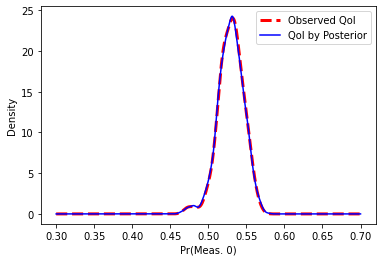

Qubit 1
Given Lambdas [0.972 0.972]
Final Accepted Posterior Lambdas
M: 2.8419 Index: 27929 pi_obs = 22.071 pi_Q(prior) = 7.76628
Accepted Number N: 14121, fraction 0.353
I(pi^post_Lambda) = 1
Posterior Lambda Mean [0.93665442 0.90849973]
Posterior Lambda Mode [0.96285839 0.92193729]
0 to 1: KL-Div(pi_D^Q(post),pi_D^obs) = 0.000707877
0 to 1: KL-Div(pi_D^obs,pi_D^Q(post)) =    inf


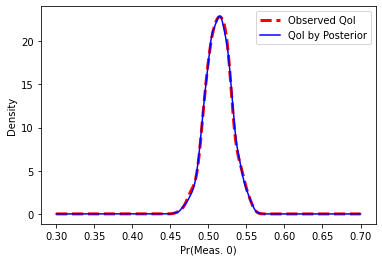

In [4]:
BJW_filter = mf.MeasFilter(interested_qubits, file_address=file_address)
BJW_filter.inference(nPrior=40000, Priod_sd=0.1, seed=127, shots_per_point=1024)
# mf.post_from_file() # if inference() is already run once

In [6]:
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[1,2], circlabel='mcal')
job = execute(meas_calibs, backend=backend,shots=8192,optimization_level=0)
job_monitor(job)

cal_results = job.result()
meas_fitter = mc.CompleteMeasFitter(cal_results,state_labels,circlabel='mcal')
meas_filter = meas_fitter.filter

Job Status: job has successfully run


In [11]:
# Create the expected density matrix
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
job = qiskit.execute(bell, Aer.get_backend('statevector_simulator'))
psi_bell = job.result().get_statevector(bell)
print(psi_bell)

# Create the actual circuit 
q2 = QuantumRegister(5)
bell = QuantumCircuit(q2)
bell.h(q2[1])
bell.cx(q2[1], q2[2])
print(bell)
# Generate the state tomography circuits. Only pass in the 
# registers we want to measure (in this case 1 and 2)
qst_bell = state_tomography_circuits(bell, [q2[1],q2[2]])

[0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
                
q4_0: ──────────
      ┌───┐     
q4_1: ┤ H ├──■──
      └───┘┌─┴─┐
q4_2: ─────┤ X ├
           └───┘
q4_3: ──────────
                
q4_4: ──────────
                


In [12]:
job_tomo = qiskit.execute(qst_bell, backend=backend, shots=8192)
job_monitor(job_tomo)
tomo_bell = StateTomographyFitter(job_tomo.result(), qst_bell)

Job Status: job has successfully run


In [49]:
tomo_bell = StateTomographyFitter(job_tomo.result(), qst_bell)
#no correction
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Fit Fidelity (no correction) =', F_bell)

Fit Fidelity (no correction) = 0.9051479187745614


In [48]:
#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_bell = StateTomographyFitter(correct_tomo_results, qst_bell)
rho_bell = tomo_bell.fit()
F_bell = state_fidelity(psi_bell, rho_bell)
print('Qiskit: Fit Fidelity (w/ correction) =', F_bell)

Qiskit: Fit Fidelity (w/ correction) = 0.9800432429717658


In [51]:
cal_matrix = meas_fitter.filter.cal_matrix

with open(file_address + 'cal_matrix1.csv', mode='w', newline='') as sgm:
    param_writer = csv.writer(sgm,
                              delimiter=',',
                              quotechar='"',
                              quoting=csv.QUOTE_MINIMAL)
    for row in cal_matrix:
        param_writer.writerow(row)
with open(file_address + 'state_labels1.csv', mode='w', newline='') as sgm:
    param_writer = csv.writer(sgm,
                              delimiter=',',
                              quotechar='"',
                              quoting=csv.QUOTE_MINIMAL)
    param_writer.writerow(state_labels)

In [25]:
first = True
for q in [2,1]:
    if first:
        postLam_mean = mf.closest_average(BJW_filter.post['Qubit' + str(q)])
        Mx = mf.errMitMat(postLam_mean)
        first = False
    else:
        postLam_mean = mf.closest_average(BJW_filter.post['Qubit' + str(q)])
        Msub = mf.errMitMat(postLam_mean)
        Mx = np.kron(Mx, Msub)
mat_mean = Mx

In [26]:
our_filter = mc.MeasurementFilter(mat_mean, state_labels)

In [27]:
#correct data
correct_tomo_results_BJW = our_filter.apply(job_tomo.result(), method='least_squares')
tomo_bell_BJW = StateTomographyFitter(correct_tomo_results_BJW, qst_bell)
rho_bell_BJW = tomo_bell_BJW.fit()
F_bell_BJW = state_fidelity(psi_bell, rho_bell_BJW)
print('BJW   : Fit Fidelity (w/ correction) =', F_bell_BJW)

BJW   : Fit Fidelity (w/ correction) = 0.9781332302515866


In [44]:
post_dict = {}
for q in interested_qubits:
    post_dict['Qubit{}'.format(q)] = pd.read_csv(
        file_address + 'StandPostQubit{}.csv'.format(q)).to_numpy()

stand_filter = ef.MeasFilterSB(interested_qubits, post_dict)
try:
    stand_filter.filter_mean(job_tomo)
except:
    pass
SB_filter = mc.MeasurementFilter(stand_filter.mat_mean, state_labels)

In [45]:
#correct data
correct_tomo_results_SB = SB_filter.apply(job_tomo.result(), method='least_squares')
tomo_bell_SB = StateTomographyFitter(correct_tomo_results_SB, qst_bell)
rho_bell_SB = tomo_bell_SB.fit()
F_bell_SB = state_fidelity(psi_bell, rho_bell_SB)
print('SB    : Fit Fidelity (w/ correction) =', F_bell_SB)

SB    : Fit Fidelity (w/ correction) = 0.9782862001146089


In [31]:
# import csv
# shots_per_point = 1024
# # Data for Standard Bayesian
# # Read data to for measurement error while input is |0>
# print('Write data for standard Bayesian')
# prop_dict = backend.properties().to_dict()
# with open(file_address + 'given_params.csv', mode='w', newline='') as sgm:
#     param_writer = csv.writer(sgm,
#                               delimiter=',',
#                               quotechar='"',
#                               quoting=csv.QUOTE_MINIMAL)
#     for q in interested_qubits:
#         p0m0 = 1 - prop_dict['qubits'][q][5]['value']
#         if p0m0 == 1 or p0m0 < 0.7:
#             p0m0 = 0.9
#         p1m1 = 1 - prop_dict['qubits'][q][4]['value']
#         if p1m1 == 1 or p1m1 < 0.7:
#             p1m1 = 0.9
#         param_writer.writerow([p0m0, p1m1])

# with open(file_address + 'Filter_data.csv', mode='r') as measfile:
#     reader = csv.reader(measfile)
#     cali01 = np.asarray([row for row in reader][0])

# Data = cali01
# for q in interested_qubits:
#     y = mf.getData0(Data, itr * int(8192 / shots_per_point), q)
#     with open(file_address + 'Qubit{}.csv'.format(q), mode='w',
#               newline='') as sgr:
#         read_writer = csv.writer(sgr,
#                                  delimiter=',',
#                                  quotechar='"',
#                                  quoting=csv.QUOTE_MINIMAL)
#         read_writer.writerow(['x', 'y'])
#         for i in range(len(y)):
#             read_writer.writerow([0.5, y[i]])

Write data for standard Bayesian
